In [1]:
%run functions.ipynb
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
X_train, X_test, y_train, y_test = load_train_and_test_parts()
print("Train and test sizes: {} {}".format(X_train.shape, X_test.shape))
print(
    "(1, 0) labels count in train test: {} {}".format(
        (np.count_nonzero(y_train == 1), np.count_nonzero(y_train == 0)),
        (np.count_nonzero(y_test == 1), np.count_nonzero(y_test == 0)),
    )
)

Train and test sizes: (726, 12179) (243, 12179)
(1, 0) labels count in train test: (289, 437) (104, 139)


In [3]:
scoring = 'roc_auc'
cv = 4
cv_out = 5
cv_in = 2
n_iter = 1
n_jobs = 3

# PCA

In [4]:
dim_params = {'n_components' : [50, 150, 300, 450, 500]}

In [5]:
models_logit_pca = fit_dim_reduction_pipeline(PCA(random_state=random_state), dim_params, X_train, y_train, 
                                              n_iter=n_iter, cv=cv, n_jobs=n_jobs, scoring=scoring)
models_logit_pca = clf_print_scores(models_logit_pca, X_train, y_train, X_test, y_test)

{'dim__n_components': 300, 'clf__solver': 'liblinear', 'clf__penalty': 'l1', 'clf__C': 0.46734693877551026}


,ROC AUC,Precision,Recall,F1
train,0.997,0.983,0.972,0.977
test,0.772,0.680,0.654,0.667


# MLCC

In [6]:
filenames = get_mlcc_result_files()
models_logit_mlcc = fit_dim_reduction_pipeline(MLCCWrapper(), {'filename' : filenames}, X_train, y_train, 
                                              n_iter=n_iter, cv=cv, n_jobs=n_jobs, scoring=scoring)
models_logit_mlcc = clf_print_scores(models_logit_mlcc, X_train, y_train, X_test, y_test)

/pio/scratch/1/i272955/anaconda3/envs/master/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'dim__filename': 'output20_4_40_30.RData', 'clf__solver': 'liblinear', 'clf__penalty': 'l1', 'clf__C': 0.21020408163265308}


,ROC AUC,Precision,Recall,F1
train,0.845,0.747,0.696,0.720
test,0.790,0.711,0.615,0.660


12
['output500_8_40_30.RData', 'output500_1_40_30.RData', 'output50_4_40_30.RData', 'output50_8_40_30.RData', 'output50_50_40_30.RData', 'output100_8_40_30.RData', 'output250_1_40_30.RData', 'output150_8_40_30.RData', 'output25_50_40_30.RData', 'output100_4_40_30.RData', 'output10_8_40_30.RData', 'output75_4_40_30.RData', 'output20_4_40_30.RData', 'output20_8_40_30.RData', 'output200_8_40_30.RData']
Highest mBIC is from output25_50_40_30.RData
[ 8 14 15 ... 12 12 12] [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


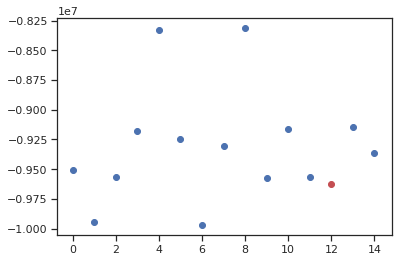

In [7]:
best_index = filenames.index(models_logit_mlcc.best_params_['dim__filename'])
print(best_index)
models_logit_mlcc.best_estimator_.steps[1][1].summary(best_index)

# SPCA

In [8]:
n_components = [50, 150, 300, 450, 600, 750, 1000]

In [9]:
dim_params = {'n_components' : n_components, 'threshold_val' : [0.01, 0.1, 0.5, 1, 3, 5, 10], 'threshold_mode': ['soft', 'hard', 'garrote'], 
              'max_iter': [25, 50, 100, 250]}

In [10]:
models_logit_spca = fit_dim_reduction_pipeline(SPCWrapper(), dim_params, X_train, y_train, 
                                               n_iter=n_iter, cv=cv, n_jobs=n_jobs, scoring=scoring)
models_logit_spca = clf_print_scores(models_logit_spca, X_train, y_train, X_test, y_test)

{'dim__threshold_val': 0.1, 'dim__threshold_mode': 'hard', 'dim__n_components': 1000, 'dim__max_iter': 25, 'clf__solver': 'liblinear', 'clf__penalty': 'l1', 'clf__C': 0.8346938775510204}


,ROC AUC,Precision,Recall,F1
train,0.981,0.963,0.910,0.936
test,0.810,0.705,0.644,0.673


## PLS

In [11]:
dim_params = {'n_components' : n_components}

In [12]:
models_logit_pls = fit_dim_reduction_pipeline(PLSRegressionWrapper(), dim_params, X_train, y_train, standardizer=stubTransformer,
                                             n_iter=n_iter, cv=cv, n_jobs=n_jobs, scoring=scoring)
models_logit_pls = clf_print_scores(models_logit_pls, X_train, y_train, X_test, y_test)

/pio/scratch/1/i272955/anaconda3/envs/master/lib/python3.7/site-packages/sklearn/cross_decomposition/pls_.py:291: UserWarning: Y residual constant at iteration 108
  warnings.warn('Y residual constant at iteration %s' % k)


{'dim__n_components': 600, 'clf__solver': 'liblinear', 'clf__penalty': 'l1', 'clf__C': 0.3571428571428572}


,ROC AUC,Precision,Recall,F1
train,1.000,1.000,1.000,1.000
test,0.818,0.667,0.750,0.706


## [fDNN](https://www.nature.com/articles/s41598-018-34833-6) model

In [13]:
clf_params = {'lr' : np.linspace(0.0001, 0.1, 50) , 'module__dropout': np.linspace(0.0, 0.4, 30), 'module__num_hidden0': [5, 10, 20, 50], 
              'module__num_hidden1': [5, 10, 20, 50], 'optimizer__weight_decay': [0.001, 0.01, 0.1, 1, 5, 10]}
dim_params = {'n_components' : [100, 250, 500], 'transformer': [RandomForestClassifier(max_depth=5, min_samples_leaf=20, random_state=random_state),
                                                               RandomLogisticsRegressions(penalty='l1', C=0.5, n_variables=500)]}

early_stopping = EarlyStopping(scoring, patience=10, threshold_mode='abs', threshold=1e-3)

In [14]:
representation_transformer = RepresentationTransformer(transformer=RandomForestClassifier())
clf = NeuralNetClassifierWrapper(ClassifierModule, train_split=None, optimizer=torch.optim.Adam, callbacks=[skorch_scoring[scoring], early_stopping], 
                          max_epochs=1000, verbose=0)


model_fdnn = fit_dim_reduction_pipeline(representation_transformer, dim_params, X_train, y_train, stubTransformer, clf, clf_params, 
                                       n_iter=n_iter, cv=cv, n_jobs=n_jobs, scoring=scoring)
model_fdnn = clf_print_scores(model_fdnn, X_train , y_train, X_test , y_test)

/pio/scratch/1/i272955/anaconda3/envs/master/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/pio/scratch/1/i272955/anaconda3/envs/master/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'dim__transformer': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False), 'dim__n_components': 250, 'clf__optimizer__weight_decay': 5, 'clf__module__num_hidden1': 50, 'clf__module__num_hidden0': 20, 'clf__module__dropout': 0.013793103448275864, 'clf__lr': 0.014371428571428571}


/pio/scratch/1/i272955/anaconda3/envs/master/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,ROC AUC,Precision,Recall,F1
train,0.813,0.000,0.000,0.000
test,0.642,0.000,0.000,0.000
